In [1]:
from notebook_utils import checkStackSetup
checkStackSetup()

You are running w_latest of lsst_distrib

No locally setup packages (using a vanilla stack)


In [2]:
import os
import json
import numpy as np
import scarlet

from lsst.afw.image import ExposureF
from lsst.afw.image import MultibandExposure
from lsst.afw.table import SourceCatalog
from lsst.geom import Point2I, Extent2I, Box2I
import lsst.meas.extensions.scarlet
from lsst.meas.extensions.scarlet.io import multibandDataToScarlet, ScarletModelData

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap='inferno', interpolation='none', origin='lower')

In [3]:
stretch = 0.2
Q = 10
norm = scarlet.display.AsinhMapping(minimum=0, stretch=stretch, Q=Q)

In [4]:
def load_blend(tract, patch, sid, pid, returnExp=False, returnModelData=False, bands=None):
    path = "/sdf/home/f/fred3m/u/data/hsc-dr4-test"
    
    # load scarlet model data
    filename = f"deepCoadd_scarletModelData_{tract}_{patch}_hsc_rings_v1_u_hsc_test_s22a_step3_20220721T111750Z.json"
    with open(os.path.join(path, filename)) as f:
        data = json.load(f)
    modelData = ScarletModelData.parse_obj(data)
    print(modelData.bands)
    del data
    if bands is None:
        bands = modelData.bands
    
    # Load the exposure
    exposures = [
        ExposureF.readFits(os.path.join(
            path,
            f"deepCoadd_calexp_{tract}_{patch}_{band}_hsc_rings_v1_u_hsc_test_s22a_step3_20220721T111750Z.fits"
        ))
        for band in bands
    ]
    blendData = modelData.blends[pid]
    bbox = Box2I(Point2I(*blendData.xy0), Extent2I(*blendData.extent))
    xmin, ymin = bbox.getMin()

    _mCalexp = MultibandExposure.fromExposures(bands, exposures)
    mCalexp = _mCalexp[:, bbox]
    del exposures
    if not returnExp:
        del _mCalexp
    
    # Load the catalog
    filename = f"deepCoadd_deblendedCatalog_{tract}_{patch}_hsc_rings_v1_u_hsc_test_s22a_step3_20220721T111750Z.fits"
    catalog = SourceCatalog.readFits(os.path.join(path, filename))
    parent = catalog[catalog["id"] == pid][0]
    footprint = parent.getFootprint()
    mask = footprint.spans.asArray()
    
    # create the blend
    blend = multibandDataToScarlet(
        modelData,
        pid,
        mExposure=mCalexp,
        footprint=footprint,
    )
    blend.mask = ~mask
    blend.peaks = np.array([
        [peak["i_y"]-ymin, peak["i_x"]-xmin]
        for peak in footprint.peaks
    ])
    
    # Add the position of the errant source
    source = catalog[catalog["id"]==sid][0]
    blend.bad = {
        "x": source["deblend_peak_center_x"]-xmin,
        "y": source["deblend_peak_center_y"]-ymin,
    }
    # Add the mask to the observation
    blend.observation.mask = mCalexp.mask.array
    blend.maskPlane = mCalexp.mask.getMaskPlaneDict()
    blend.catalog = catalog
    blend.footprint = footprint
    if returnExp or returnModelData:
        result = (blend, )
        if returnExp:
            result += (_mCalexp,)
        if returnModelData:
            result += (modelData,)
        return result
    return blend

In [5]:
tract=9322
patch=34
sid = 3321035289278830119
pid = 3321035289278811042

blend = load_blend(tract, patch, sid, pid)

['g', 'i', 'r', 'y', 'z']


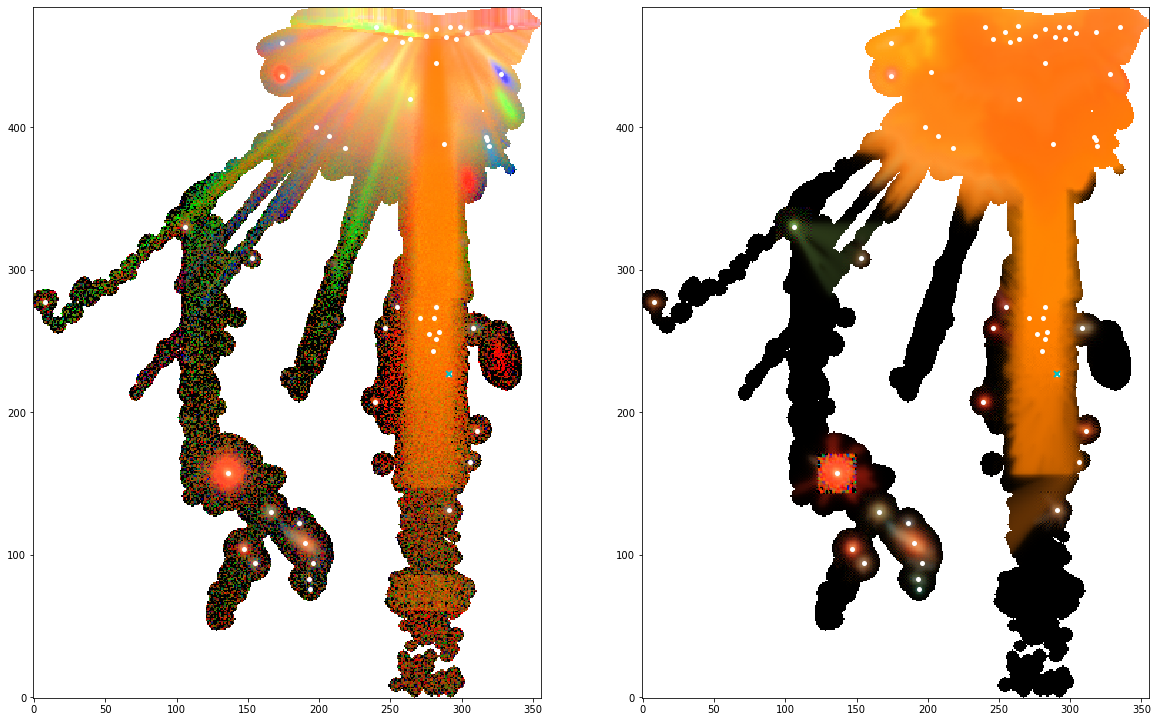

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))
rgb = scarlet.display.img_to_rgb(blend.observation.images, norm=norm, mask=blend.mask)
ax[0].imshow(rgb)
rgb = scarlet.display.img_to_rgb(blend.get_model(convolve=True), norm=norm, mask=blend.mask)
ax[1].imshow(rgb)

ax[0].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[0].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
ax[1].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[1].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
plt.show()

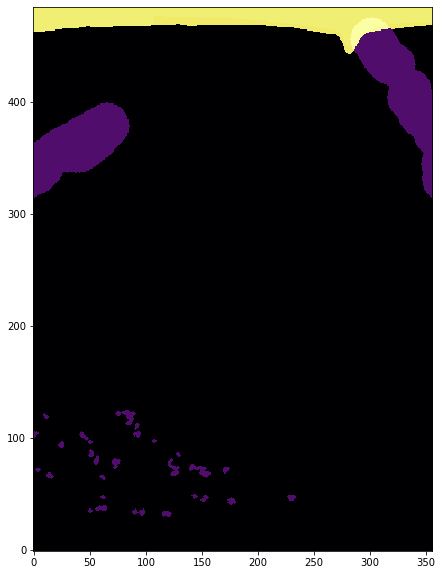

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(np.bitwise_or.reduce(blend.observation.mask, axis=0))
plt.show()

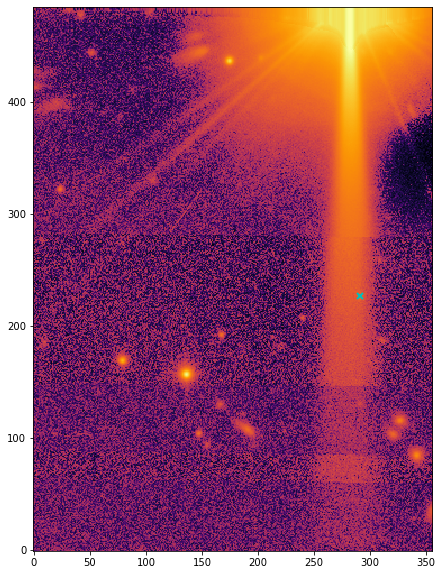

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(np.arcsinh(10*blend.observation.images[3])/10)
plt.plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
plt.show()

In [9]:
sid = 3494085225351251870
pid = 3494085225351226216
tract = 9808
patch = 15

blend, exp = load_blend(tract, patch, sid, pid, returnExp=True)

['g', 'i', 'r', 'y', 'z']


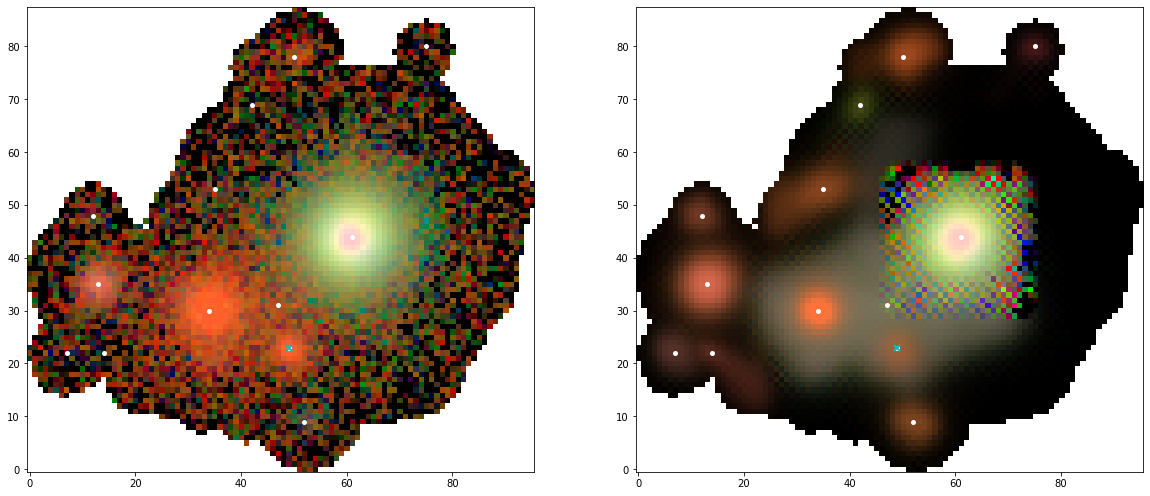

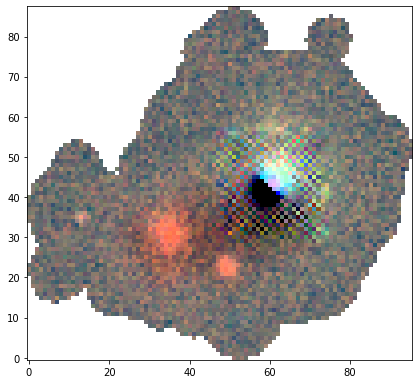

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))
rgb = scarlet.display.img_to_rgb(blend.observation.images, norm=norm, mask=blend.mask)
ax[0].imshow(rgb)
model = blend.get_model()
convolved = blend.observation.convolve(model, mode="real")
rgb = scarlet.display.img_to_rgb(convolved, norm=norm, mask=blend.mask)
ax[1].imshow(rgb)

ax[0].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[0].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
ax[1].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[1].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
plt.show()

residual = blend.observation.images - convolved
plt.figure(figsize=(10, 6.5))
rgb = scarlet.display.img_to_rgb(residual, mask=blend.mask, norm=scarlet.display.LinearPercentileNorm(residual))
plt.imshow(rgb)

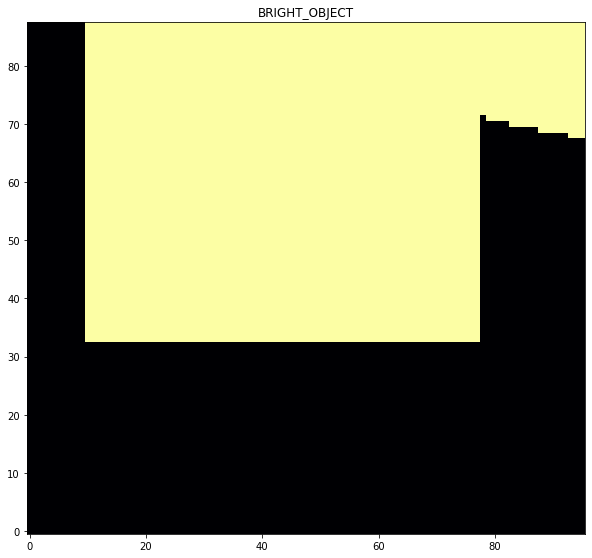

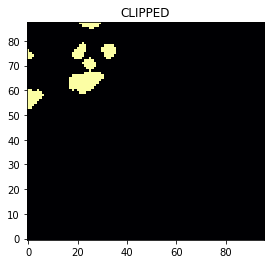

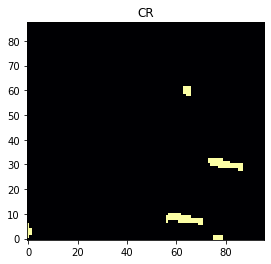

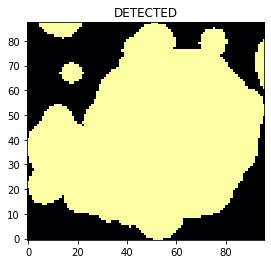

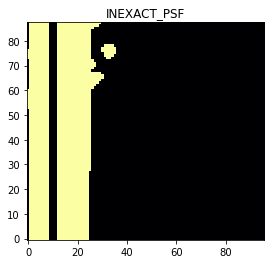

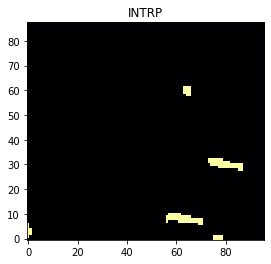

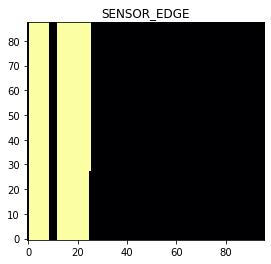

In [11]:
plt.figure(figsize=(10, 10))
for key, bit in blend.maskPlane.items():
    mask = np.bitwise_or.reduce(blend.observation.mask & 2**bit, axis=0)
    if np.sum(mask) != 0:
        plt.imshow(mask)
        plt.title(key)
        plt.show()

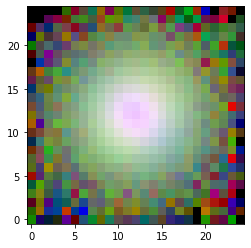

In [12]:
psfNorm = scarlet.display.AsinhMapping(minimum=0, stretch=.0001, Q=10)
rgb = scarlet.display.img_to_rgb(blend.observation.psfs, norm=psfNorm)
plt.imshow(rgb)
plt.show()

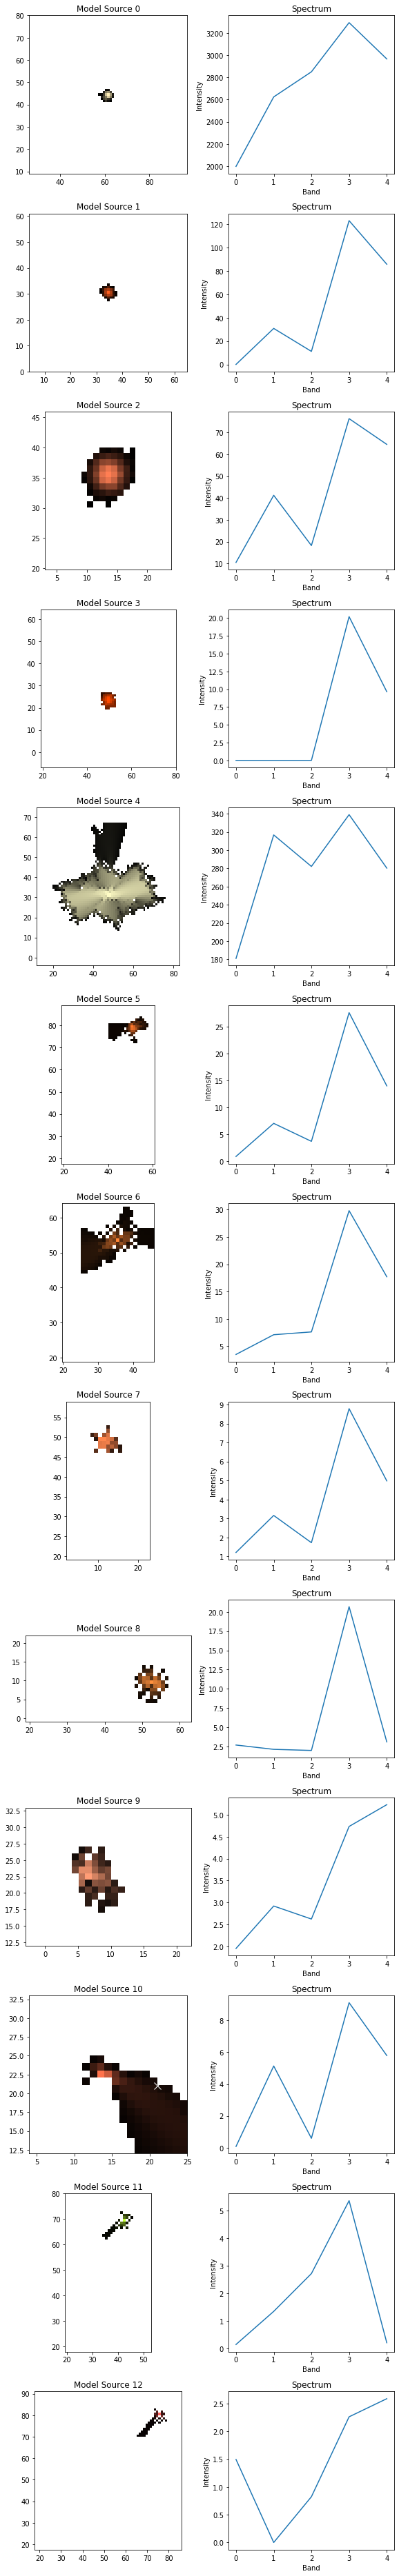

In [13]:
scarlet.lite.display.show_sources(blend)
plt.show()

In [14]:
from lsst.meas.extensions.scarlet import deblend_lite, ScarletDeblendConfig

config = ScarletDeblendConfig()
config.minIter = 15
config.relativeError = 1e-4
_blend, _ = deblend_lite(exp, blend.observation.model_psf[0], blend.footprint, config, True)

/sdf/group/rubin/sw/conda/envs/lsst-scipipe-4.1.0/share/eups/Linux64/scarlet/g9f0f391e47+4083830bf8/lib/python/scarlet/lite/models.py:119: RuntimeWarning: invalid value encountered in true_divide
  if np.any(edge_flux/edge_mask > self.bg_thresh*self.bg_rms[:, None, None]):


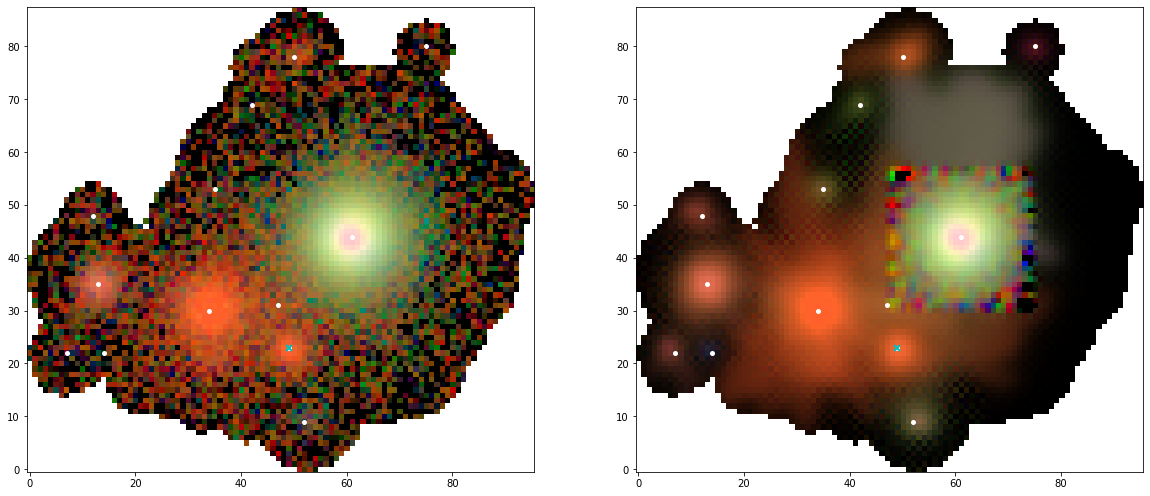

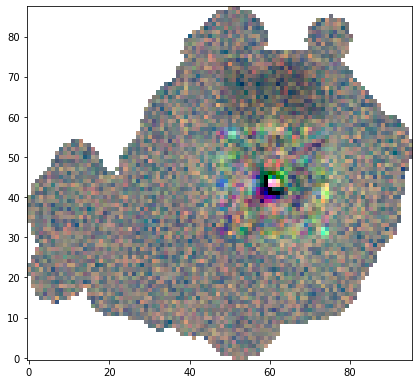

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))
rgb = scarlet.display.img_to_rgb(blend.observation.images, norm=norm, mask=blend.mask)
ax[0].imshow(rgb)
model = _blend.get_model()
convolved = blend.observation.convolve(model, mode="real")
rgb = scarlet.display.img_to_rgb(convolved, norm=norm, mask=blend.mask)
ax[1].imshow(rgb)

ax[0].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[0].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
ax[1].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[1].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
plt.show()

residual = blend.observation.images - convolved
plt.figure(figsize=(10, 6.5))
rgb = scarlet.display.img_to_rgb(residual, mask=blend.mask, norm=scarlet.display.LinearPercentileNorm(residual))
plt.imshow(rgb)

In [16]:
len(_blend.loss)

300

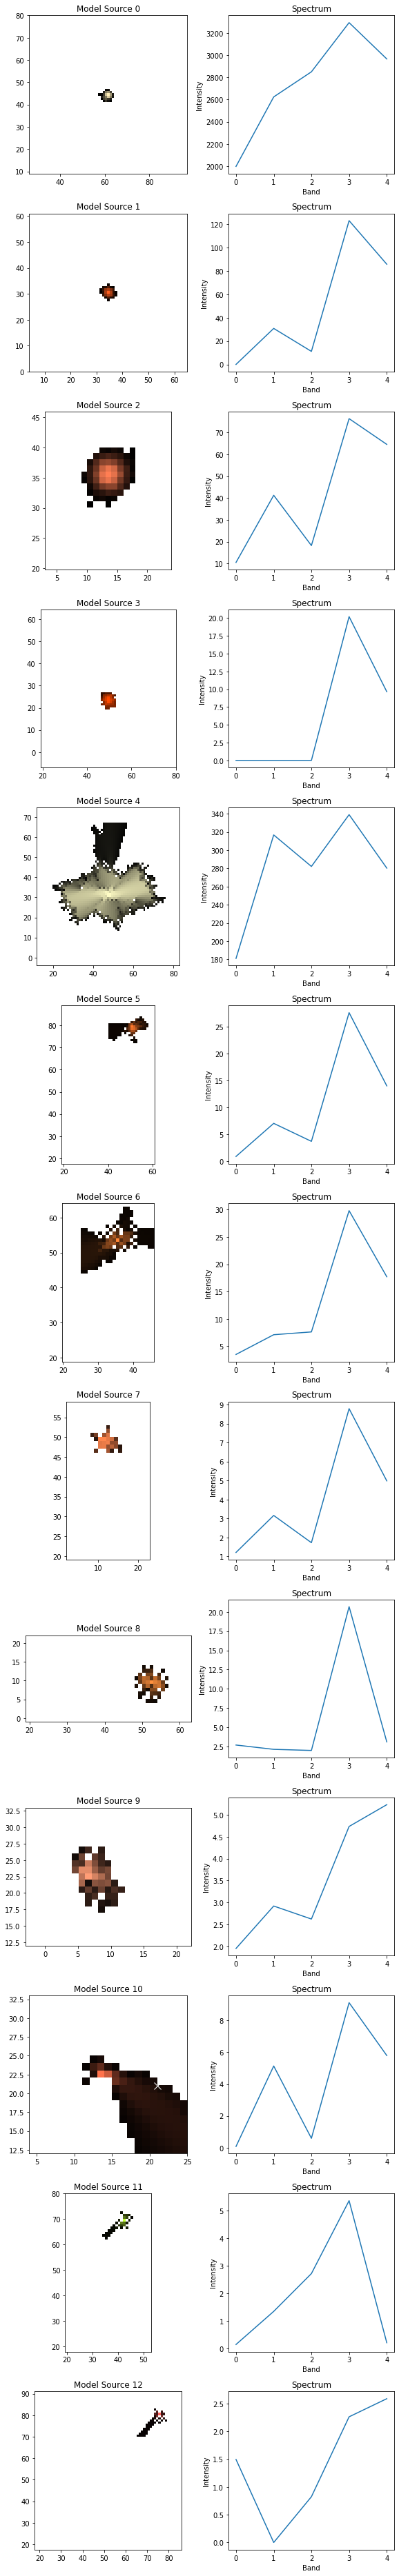

In [17]:
scarlet.lite.display.show_sources(blend)
plt.show()

In [18]:
sid = 3408024251221958751
pid = 3408024251221937034
tract = 9566
patch = 49

blend = load_blend(tract, patch, sid, pid)

['g', 'i', 'r', 'y', 'z']


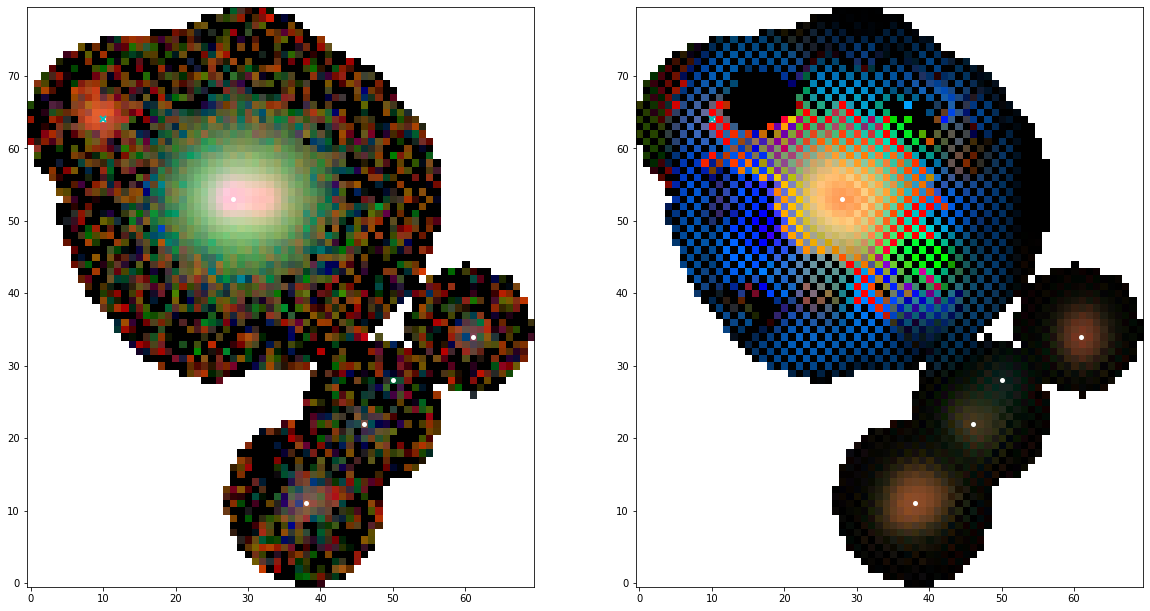

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))
rgb = scarlet.display.img_to_rgb(blend.observation.images, norm=norm, mask=blend.mask)
ax[0].imshow(rgb)
model = blend.get_model()
convolved = blend.observation.convolve(model, mode="real")
rgb = scarlet.display.img_to_rgb(convolved, norm=norm, mask=blend.mask)
ax[1].imshow(rgb)

ax[0].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[0].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
ax[1].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[1].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
plt.show()

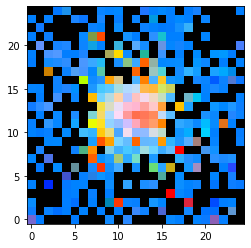

In [20]:
psfNorm = scarlet.display.AsinhMapping(minimum=0, stretch=.0001, Q=10)
rgb = scarlet.display.img_to_rgb(blend.observation.psfs, norm=psfNorm)
plt.imshow(rgb)
plt.show()

In [21]:
sid = 3494916456141835893
pid = 3494916456141818360
tract = 9810
patch = 42

blend, exp, modelData = load_blend(tract, patch, sid, pid, returnExp=True, returnModelData=True)

['g', 'i', 'r', 'y', 'z']


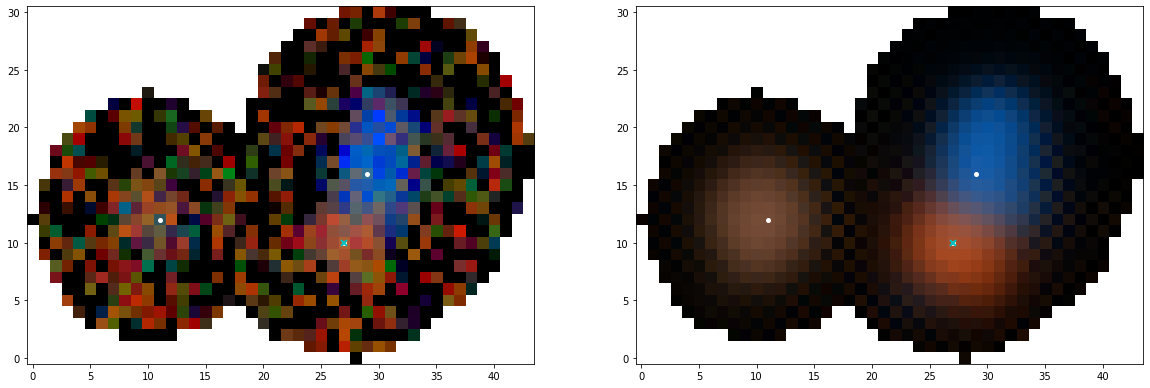

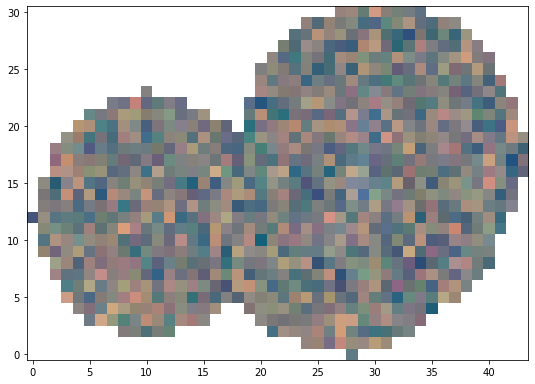

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))
rgb = scarlet.display.img_to_rgb(blend.observation.images, norm=norm, mask=blend.mask)
ax[0].imshow(rgb)
model = blend.get_model()
convolved = blend.observation.convolve(model, mode="real")
rgb = scarlet.display.img_to_rgb(convolved, norm=norm, mask=blend.mask)
ax[1].imshow(rgb)

ax[0].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[0].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
ax[1].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[1].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
plt.show()

residual = blend.observation.images - convolved
plt.figure(figsize=(10, 6.5))
rgb = scarlet.display.img_to_rgb(residual, mask=blend.mask, norm=scarlet.display.LinearPercentileNorm(residual))
plt.imshow(rgb)

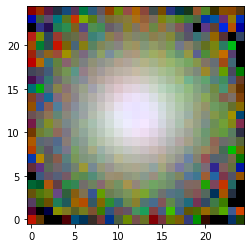

In [23]:
psfNorm = scarlet.display.AsinhMapping(minimum=0, stretch=.0001, Q=10)
rgb = scarlet.display.img_to_rgb(blend.observation.psfs, norm=psfNorm)
plt.imshow(rgb)
plt.show()

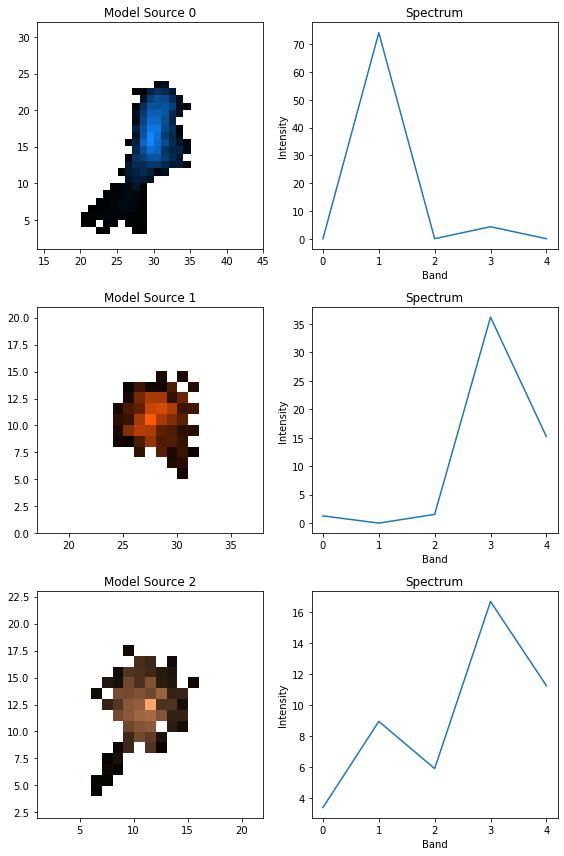

In [24]:
scarlet.lite.display.show_sources(blend)
plt.show()

In [25]:
-2.5*np.log10(np.sum(blend.sources[1].get_model(), axis=(1, 2)))+25

array([24.734974, 29.956844, 24.53062 , 21.10346 , 22.045074],
      dtype=float32)

In [26]:
sid = 3409198529640418893
pid = 3409198529640400358
tract = 9569
patch = 73
blend = load_blend(tract, patch, sid, pid)

['g', 'i', 'r', 'y', 'z']


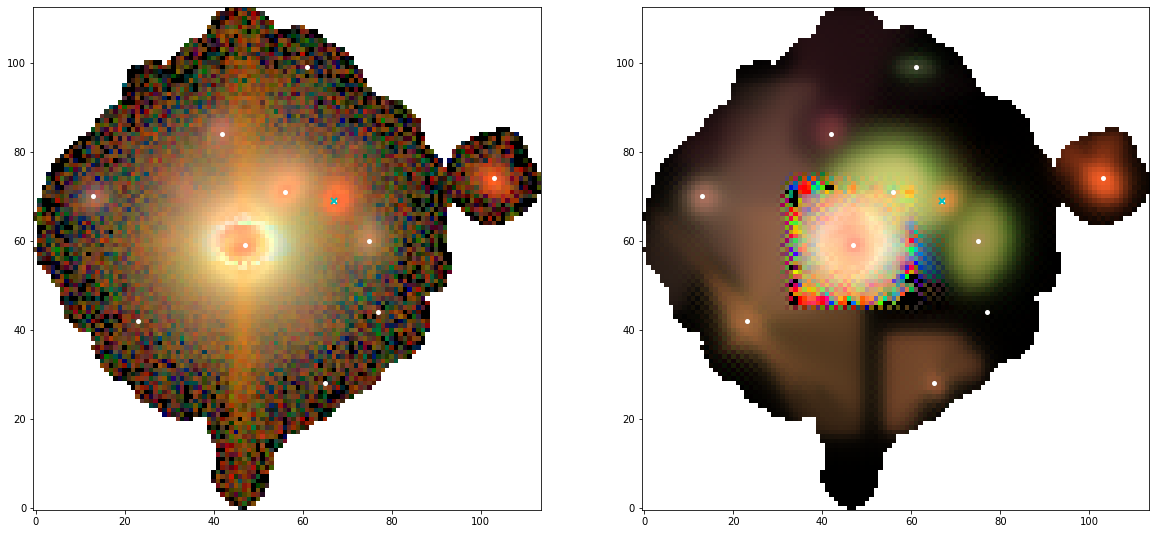

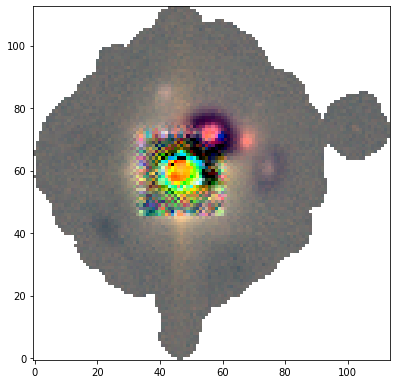

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))
rgb = scarlet.display.img_to_rgb(blend.observation.images, norm=norm, mask=blend.mask)
ax[0].imshow(rgb)
model = blend.get_model()
convolved = blend.observation.convolve(model, mode="real")
rgb = scarlet.display.img_to_rgb(convolved, norm=norm, mask=blend.mask)
ax[1].imshow(rgb)

ax[0].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[0].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
ax[1].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[1].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
plt.show()

residual = blend.observation.images - convolved
plt.figure(figsize=(10, 6.5))
rgb = scarlet.display.img_to_rgb(residual, mask=blend.mask, norm=scarlet.display.LinearPercentileNorm(residual))
plt.imshow(rgb)

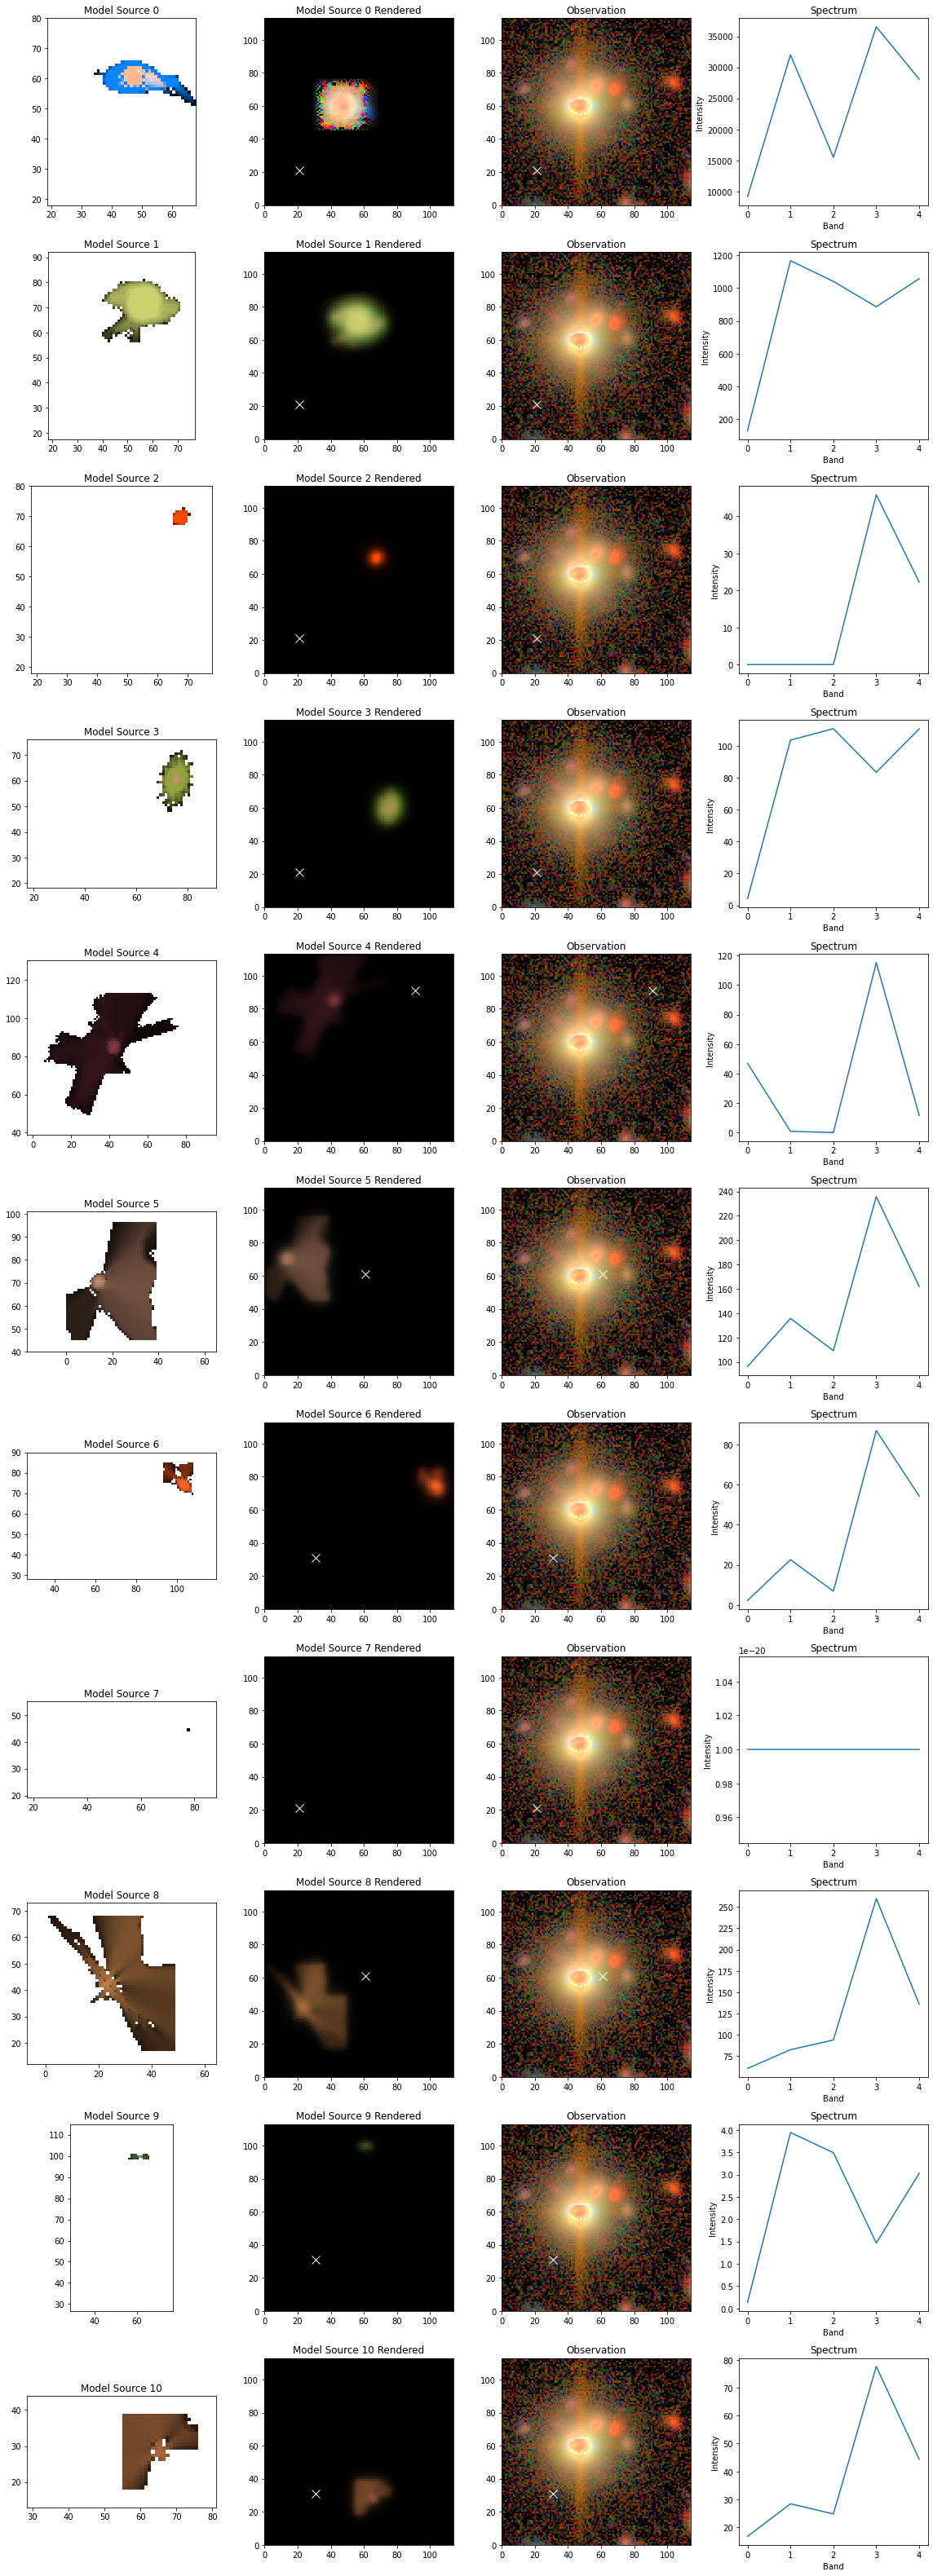

In [28]:
scarlet.lite.display.show_sources(blend, show_observed=True, show_rendered=True, norm=norm)
plt.show()

In [29]:
sid = 3497150663769480726
pid = 3497150663769460318
tract = 9816
patch = 64

blend = load_blend(tract, patch, sid, pid)

['g', 'i', 'r', 'y', 'z']


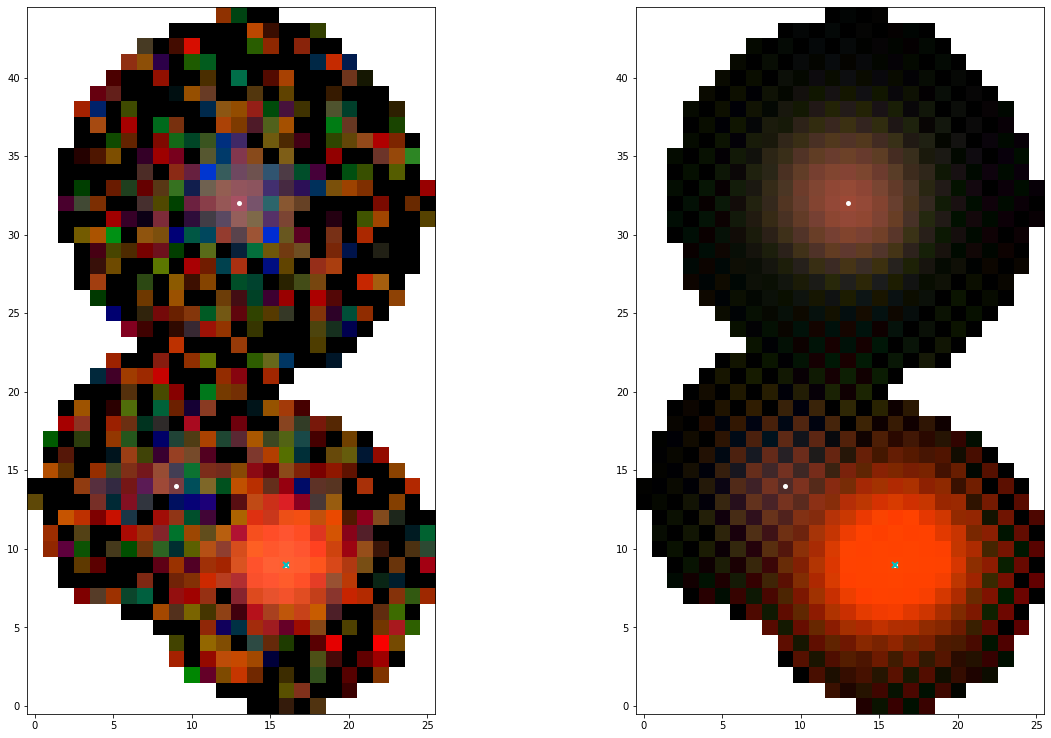

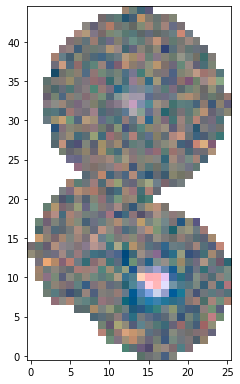

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(20, 13))
rgb = scarlet.display.img_to_rgb(blend.observation.images, norm=norm, mask=blend.mask)
ax[0].imshow(rgb)
model = blend.get_model()
convolved = blend.observation.convolve(model, mode="real")
rgb = scarlet.display.img_to_rgb(convolved, norm=norm, mask=blend.mask)
ax[1].imshow(rgb)

ax[0].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[0].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
ax[1].plot(blend.peaks[:, 1], blend.peaks[:, 0], "w.", mew=2)
ax[1].plot(blend.bad["x"], blend.bad["y"], "cx", mew=2)
plt.show()

residual = blend.observation.images - convolved
plt.figure(figsize=(10, 6.5))
rgb = scarlet.display.img_to_rgb(residual, mask=blend.mask, norm=scarlet.display.LinearPercentileNorm(residual))
plt.imshow(rgb)

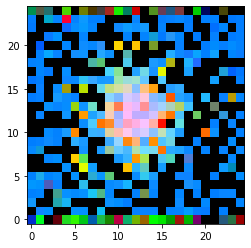

In [31]:
psfNorm = scarlet.display.AsinhMapping(minimum=0, stretch=.0001, Q=10)
rgb = scarlet.display.img_to_rgb(blend.observation.psfs, norm=psfNorm)
plt.imshow(rgb)
plt.show()